# Introduction

# Setup

## Helper Functions

In [33]:
def visualize(model, X, y, h=0.01):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    #performing predictions on grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # plotting the results
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # plotting training points
    plt.scatter(X[:, 0], X[:, 1])
    plt.show()

## Imports

In [2]:
import sys
import warnings
import time
from IPython import display

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, make_blobs

# KMeans

In [3]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, k=8, max_iter=300, tol=0.0001, animate=False):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.animate = animate

        
    @property
    def cluster_centers_(self):
        return self._cluster_centers

    @property
    def clusters_(self):
        return self._clusters
    
    @property
    def cost_(self):
        return self._cost
    
    
    def fit(self, X):
        self.X = X
        self._check_params(self.X)
        self._kmeans(self.X)
        self.fitted_ = True
        
        return self
    
    
    def _kmeans(self, X):
        centroids = []
        
        #initially taking first "k" points as centroids
        for i in range(self.k):
            centroids.append(X[i])

        clusters = {}
        for _ in range(self.max_iter):
            if self.animate == True:
                self._animate(X, np.array(centroids))
            
            #resetting each cluster
            for i in range(self.k):
                clusters[i] = []

            #inserting each point to its respective cluster
            for point in X:
                # computing eucledian distances of current point from each centroid
                distances = [np.linalg.norm(centroid-point) for centroid in centroids]

                # getting index of closest cluster
                index = np.argmin(distances)

                # appending point(feature set) to list of cluster it belongs to
                clusters[index].append(point)

                
            #computing new centroids
            old_centroids = list(centroids)
            for i in range(self.k):
                # computing new centroid by taking mean of all points in current cluster
                new_centroid = np.mean(clusters[i], axis=0)

                #setting new centroid
                centroids[i] = new_centroid
                

            optimized = True
            for i in range(self.k):
                #if not np.array_equal(centroids[i], old_centroids[i]):
                if not np.allclose(centroids[i], old_centroids[i], atol=self.tol):
                    optimized = False
                    break
            if optimized:
                break
        
        self._cluster_centers = np.array(centroids)
        self._clusters = clusters
        
        #converting each cluster to ndarrays
        for i in range(self.k):
            self._clusters[i] = np.array(self._clusters[i])
            
        #getting cost
        self._cost = self._cost(self._cluster_centers, self._clusters)
        
    
    def _cost(self, centroids, clusters):
        cost = 0
        for i in range(self.k):
            for point in clusters[i]:
                cost += np.linalg.norm(centroids[i]-point)
                
        return cost


    def predict(self, X):
        y_preds = []
        for point in X:
            # computing  eucledian distances between given point and centroids
            distances = [np.linalg.norm(centroid-point) for centroid in self._cluster_centers]

            #cendroid with minimum distance
            y_preds.append(np.argmin(distances))
        
        return np.array(y_preds)
    
        
    def _animate(self, X, centroids):
        plt.gca().cla() 
    
        plt.scatter(X[:,0], X[:,1])
        plt.scatter(centroids[:,0], centroids[:,1])
    
        display.display(plt.gcf()) 
        display.clear_output(wait=True)
        
    
    def _check_params(self, X):
        if self.k is 0:
            warnings.warn('k cannot be equal to 0')
            self.k = 8
            
        if self.animate == True and X.shape[1] != 2:
            warnings.warn('cannot animate datapoints with more than 2 features')
            self.animate = False

# CustomKMeans vs KMeans

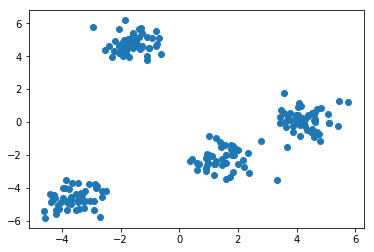

In [21]:
#creating clusters
X,y = make_blobs(n_features=2, n_samples=200, centers=4, cluster_std=0.6)

#plotting data
plt.scatter(X[:,0], X[:,1])
plt.show()

In [22]:
skModel = KMeans(n_clusters=4).fit(X)
custModel = CustomKMeans(k=4).fit(X)

In [23]:
print(skModel.cluster_centers_)
print()
print(custModel.cluster_centers_)

[[ 1.4439881  -2.23708535]
 [-3.60702631 -4.65842392]
 [-1.58861415  4.7844408 ]
 [ 4.30601678  0.12684328]]

[[-1.58861415  4.7844408 ]
 [ 1.4439881  -2.23708535]
 [-3.60702631 -4.65842392]
 [ 4.30601678  0.12684328]]


### Plotting CustomKMeans Results

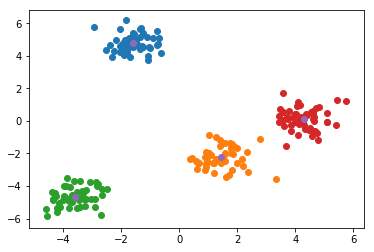

In [24]:
#plotting clusters
for k in custModel.clusters_:
    plt.scatter(custModel.clusters_[k][:,0], custModel.clusters_[k][:,1])
    
#plotting cluster centers
plt.scatter(custModel.cluster_centers_[:,0], custModel.cluster_centers_[:,1])
plt.show()

### Plotting KMeans Results

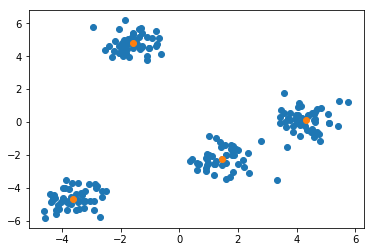

In [26]:
#plotting data
plt.scatter(X[:,0], X[:,1])
    
#plotting cluster centers
plt.scatter(skModel.cluster_centers_[:,0], skModel.cluster_centers_[:,1])
plt.show()

## Visualizing KMeans Decision Boundary

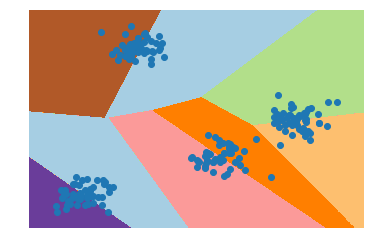

In [34]:
visualize(X=X, y=y, model=KMeans().fit(X,y))

# Cost vs k (skree Plot)
Cost is defined as sum of total variance (distance) between cluster points and its center for all the clusters
### $\sum_{i=1}^{k} \sum_{j=1}^{n} ||c_i - x_j||_2$
where:<br>
**k**: total no of clusters<br>
**n**: total no of points<br>
**x**: data point<br>
**c**: cluster center<br>
<br>

From plot below it is evident that best value for k is 3 because for **k** in *1-3* there is a significant decrease in cost but for **k** in range *4-9* there is no significant improvement in cost, rather we only have marginal improvements, suggesting that we are overfitting and our clusters are becoming too small.

In next section we look at the results of *k estimation* using **silhouette analysis**.

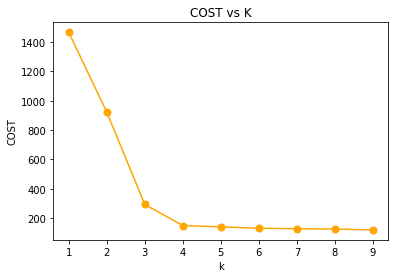

In [72]:
ks = np.arange(1, 10)
costs = []
for k in ks:
    tempModel = CustomKMeans(k=k).fit(X)
    costs.append(tempModel.cost_)

plt.plot(ks, costs, markersize="7", marker='o', c='orange')

plt.xlabel('k')
plt.ylabel('COST')
plt.title('COST vs K')
plt.show()

# k Estimation using Silhouette Analysis

In [195]:
def silhouette_score(X, labels):
    scores = []
    df = pd.DataFrame(X)
    df['y'] = labels
    
    if len(np.unique(labels)) == 1:
        warnings.warn('k cannot be 1 for evaluating silhouette score')
        return
    
    #grouping items as per their cluster labels
    groups = df.groupby('y')
    
    #computing cluster centers
    centers = {}
    for label, cluster in groups:
         centers[label] = cluster.values[:,0:-1].mean(axis=0)
    
    #computing silhouette score
    for label, cluster in groups:
        #computing distance between current cluster and all other clusters
        distances = {}
        for _label in centers:
            if label != _label:
                distances[_label] = np.linalg.norm(centers[label] - centers[_label])
        
        #getting label of closest cluster
        closest_cluster_label = min(distances, key=lambda k: distances[k])
        
        #getting closest cluster
        closest_cluster = groups.get_group(closest_cluster_label)
        
        for _,row in cluster.iterrows():
            #getting current point (Series => ndarray => all except label column)
            current_point = row.values[0:-1]
            
            #getting all points in current cluster
            points = cluster.values[:,0:-1]
            
            #getting mean distance of current point from each point in current clusters
            a = np.mean([np.linalg.norm(current_point-point) for point in points])
            
            #getting mean distance of current point from each point in closest clusters
            b = np.mean([np.linalg.norm(current_point-point) for point in closest_cluster.values[:,0:-1]])
            
            #computing score
            score = (b-a)/max(a,b)
            scores.append(score)
    
    return np.mean(scores)

In [196]:
def silhouette_samples(X, labels):
    scores = {}
    df = pd.DataFrame(X)
    df['y'] = labels
    
    if len(np.unique(labels)) == 1:
        warnings.warn('k cannot be 1 for evaluating silhouette score')
        return
    
    #grouping items as per their cluster labels
    groups = df.groupby('y')
    
    #computing cluster centers
    centers = {}
    for label, cluster in groups:
         centers[label] = cluster.values[:,0:-1].mean(axis=0)
    
    #computing silhouette score
    for label, cluster in groups:
        scores[label] = []
        
        #computing distance between current cluster and all other clusters
        distances = {}
        for _label in centers:
            if label != _label:
                distances[_label] = np.linalg.norm(centers[label] - centers[_label])
        
        #getting label of closest cluster
        closest_cluster_label = min(distances, key=lambda k: distances[k])
        
        #getting closest cluster
        closest_cluster = groups.get_group(closest_cluster_label)
        
        for _,row in cluster.iterrows():
            #getting current point (Series => ndarray => all except label column)
            current_point = row.values[0:-1]
            
            #getting all points in current cluster
            points = cluster.values[:,0:-1]
            
            #getting mean distance of current point from each point in current clusters
            a = np.mean([np.linalg.norm(current_point-point) for point in points])
            
            #getting mean distance of current point from each point in closest clusters
            b = np.mean([np.linalg.norm(current_point-point) for point in closest_cluster.values[:,0:-1]])
            
            #computing score
            score = (b-a)/max(a,b)
            scores[label].append(score)
    
    return scores

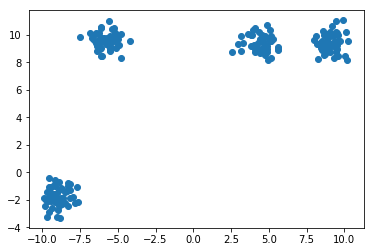

In [98]:
#creating clusters
X,y = make_blobs(n_features=2, centers=4, n_samples=200, cluster_std=0.7)

#plotting data
plt.scatter(X[:,0], X[:,1])
plt.show()

### Visualizing Silhouette scores

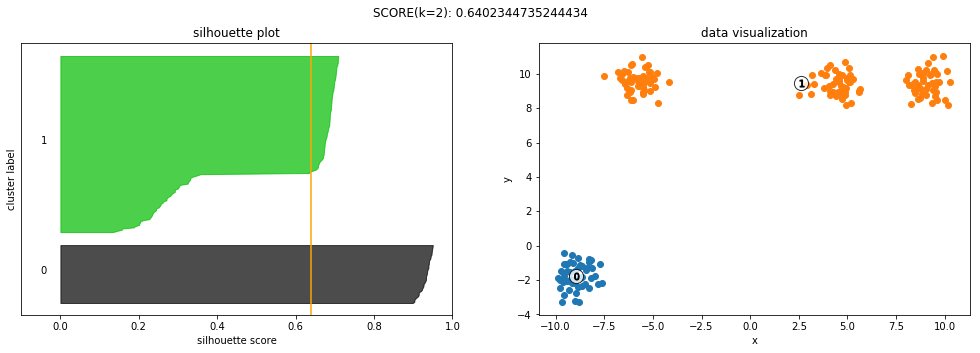

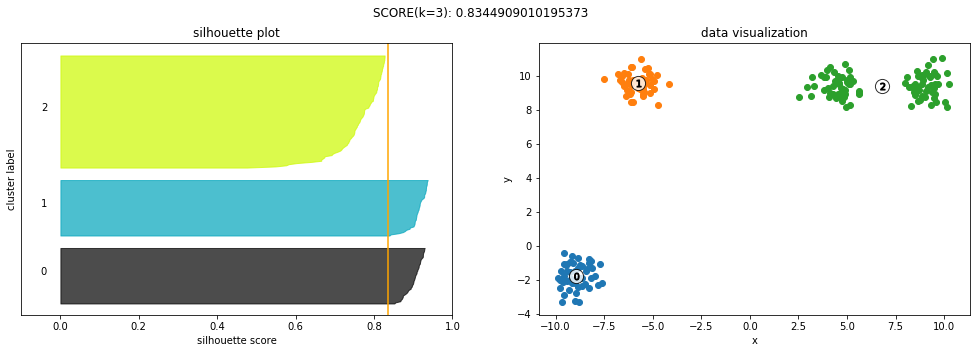

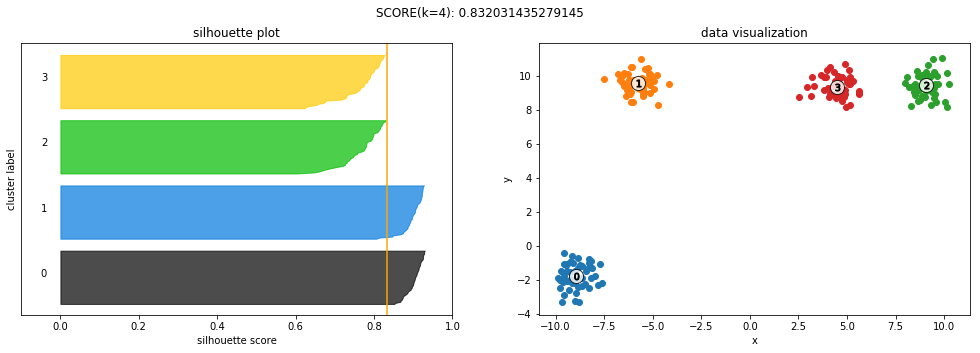

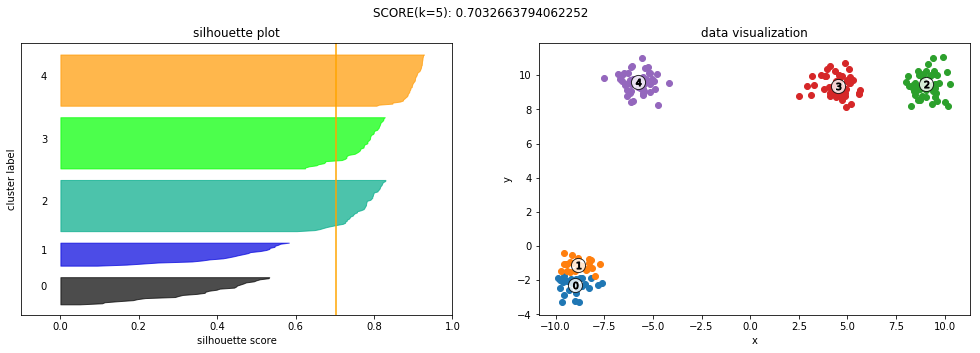

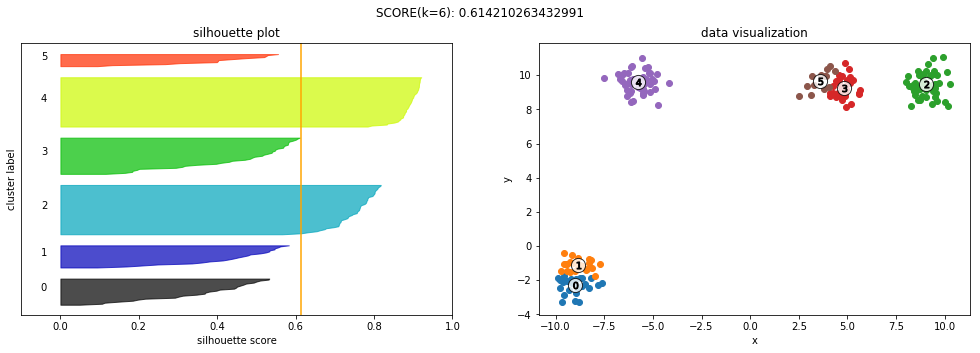

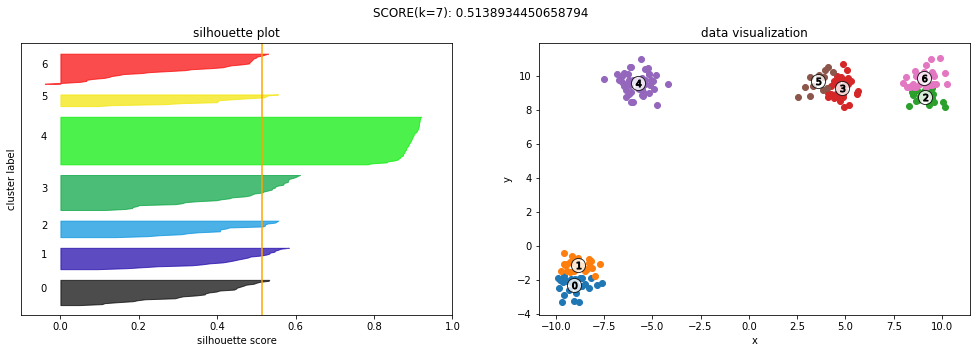

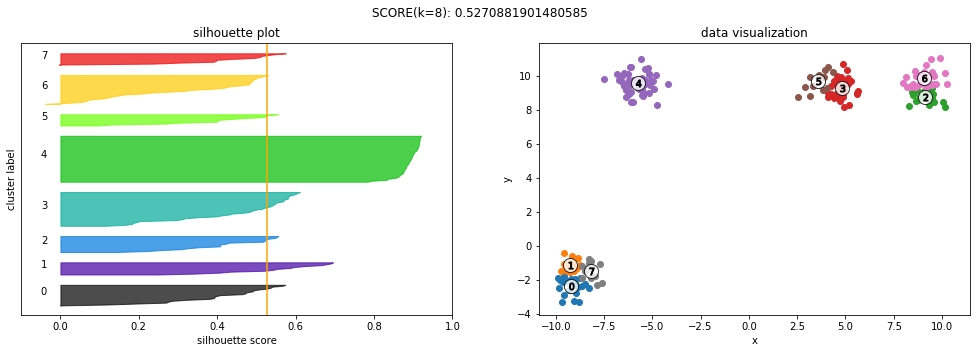

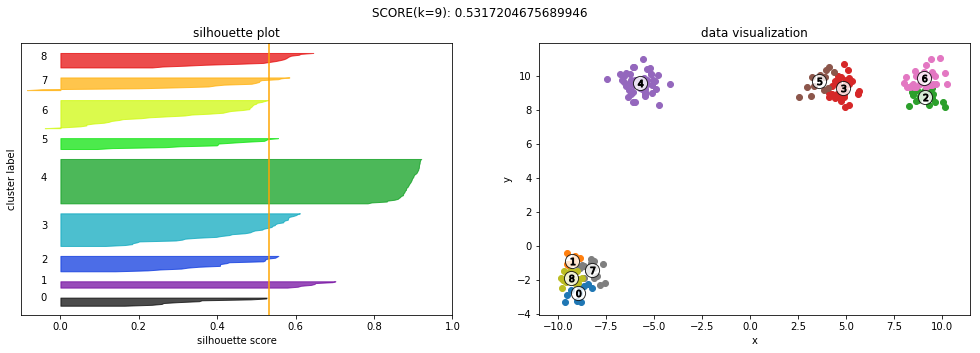

In [197]:
import matplotlib.cm as cm

ks = np.arange(2,10)
for k in ks:
    #creating subplots
    figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    figure.set_size_inches(17, 5)
    
    #setting limits to our axes
    #note: silhouette score ranges in [-1,1]
    #since our scores are all positive we are taking [-0.1,1]
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    #training model current value of "k"
    model = CustomKMeans(k=k).fit(X)
    clusters = model.clusters_
    centers = model.cluster_centers_
    
    #getting labels for each point
    labels = model.predict(X)
    
    #getting average silhouette score
    score = silhouette_score(X, labels)

    #getting silhouette score for each point
    scores = silhouette_samples(X, labels)
    
    
    y_lower = 10
    #silhouette plot
    for i in range(k):
        cluster_scores = scores[i]
        cluster_scores.sort()
        
        size_0 = clusters[i].shape[0]
        y_upper = y_lower + size_0
        
        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_scores,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_0, str(i))
        y_lower = y_upper + 10
        
        
    #plotting the average score line
    ax1.axvline(x=score, color="orange", linestyle="-")
        
    #plotting clusters
    for key in clusters:
        ax2.scatter(clusters[key][:,0], clusters[key][:,1])

    #plotting cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o'.format(i), c='white', s=200, edgecolor='k', alpha=0.8)
    for i in range(k):
        ax2.scatter(centers[i,0], centers[i,1], marker='${0}$'.format(i), c='black', s=50, edgecolor='k')
    
    #customizations
    plt.suptitle('SCORE(k={0}): {1}'.format(k, score))
    ax1.set_title('silhouette plot')
    ax2.set_title('data visualization')
    ax1.set_yticks([])
    
    ax1.set_xlabel('silhouette score')
    ax1.set_ylabel('cluster label')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
plt.show()